In [12]:
import inspect
import logging
import os

import pandas as pd
from csrank.util import setup_logging
import numpy as np
from constants import DCMS
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
plt.style.use('default')
from itertools import product
#sns.set_style("dark")
from constants import DCMS

Using TensorFlow backend.


In [13]:
def get_max_min(maxi, mini, acc):
    if np.max(acc) > maxi:
        maxi = np.max(acc)
    if np.min(acc) < mini:
        mini = np.min(acc)
    return np.around(maxi,2), np.around(mini,2)

In [14]:
def generate_df(dataset, dataset_type):
    merge_df = os.path.join(DIR_PATH, RESULT_FOLDER, "performance_sets_{}_{}.csv".format(dataset, dataset_type))
    df_path = os.path.join(DIR_PATH, RESULT_FOLDER, "performance_sets_{}_{}_{}.csv".format(dataset, dataset_type, "{}"))
    for_results = os.path.join(DIR_PATH, 'detailedresults', "choice_set_size_experiment_{}_{}.csv".format(dataset.split('_dc')[0], dataset_type))
    for learner in DCMS:
        path = df_path.format(learner)
        if os.path.isfile(path):
            df = pd.read_csv(path, index_col=0)
            if not os.path.isfile(merge_df):
                dataFrame = df
            else:
                dataFrame = pd.read_csv(merge_df, index_col=0)
                for col in list(df.columns):
                    if col!=objects:
                        dataFrame[col] = np.array(df[col])
            dataFrame.to_csv(merge_df, index=objects)
    df = dataFrame.copy()
    for col in df.columns:
        if col ==objects:
            continue
        new_col = col
        if "_gen" in col:
            new_col = models_dict[new_col.split('_gen')[0]] + "_generalization"
        elif "_optimized" in col:
            del df[col]
        else:
            new_col = models_dict[col] + "_performance"
        df.rename(index=str, columns={col: new_col}, inplace=True)
    df.to_csv(for_results)
    N_OBJECTS_ARRAY = dataFrame[objects].as_matrix()
    return dataFrame, N_OBJECTS_ARRAY

In [15]:
def plot_df(dataFrame, N_OBJECTS_ARRAY, dataset_type):
    mins = 1/N_OBJECTS_ARRAY
    maxi = 0
    mini = 100
    fig, sub_plot = plt.subplots(figsize=(8, 6))
    fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
    plot_file = plot_file_per.format(dataset_type)
    j = 0
    for learner, model in zip(DCMS,models):
        if learner in list(dataFrame.columns) and not plot_gen:
            acc = (dataFrame[learner].as_matrix() - mins)/(1.0 - mins)
            sub_plot.plot(N_OBJECTS_ARRAY, acc, label=model, marker=markers[j], linewidth=1, color=cycle[j])
            maxi, mini = get_max_min(maxi, mini, acc)
        if learner+"_gen" in list(dataFrame.columns) and plot_gen:
            acc = (dataFrame[learner+"_gen"].as_matrix() - mins)/(1.0-mins)
            sub_plot.plot(N_OBJECTS_ARRAY, acc, label=model, marker=markers[j], linewidth=1, color=cycle[j])
            maxi, mini = get_max_min(maxi, mini, acc)
        j = j+1
    acc = N_OBJECTS_ARRAY*0
    #sub_plot.plot(N_OBJECTS_ARRAY, acc, label='RANDOM', linewidth=1, color='k', marker='H')

        #if learner+"_optimized" in list(dataFrame.columns):
        #    acc_opt = (dataFrame[learner+"_optimized"].as_matrix() - mins)/(1.0-mins) 
            #plt.plot([5, 7, 15, 17], acc_opt[[2,4,12,14]], label=learner+"_optimized", marker="o")
    if plot_gen:
        plot_file = plot_file_gen.format(dataset_type)
    fig_param['fname'] = plot_file
    sub_plot.set_ylabel(y_label)
    sub_plot.set_xlabel(x_label)
    plt.xticks(N_OBJECTS_ARRAY)
    plt.yticks(np.arange(mini-0.1,maxi+0.3,0.1))
    plt.legend(ncol=3, fancybox=False, shadow=False, frameon=True, facecolor='white', edgecolor='k')
    plt.savefig(**fig_param)
    plt.show()
    print(plot_file)

In [16]:
def plot_df2(dataset, dfs, dts):
    fig, axs = plt.subplots(1, 2, figsize=(15,6), sharey=False, frameon=True, edgecolor='k', facecolor='white')
    fig.subplots_adjust(hspace=0)
    fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
    plot_file = plot_file_per.format(dataset.split('_dc')[0])
    maxi = 0
    mini = 100
    for i, data in enumerate(dfs):
        dataFrame, N_OBJECTS_ARRAY = data[0], data[1]
        mins = 1/N_OBJECTS_ARRAY
        sub_plot = axs[i]
        j = 0
        for learner, model in zip(DCMS,models):
            if learner in list(dataFrame.columns) and not plot_gen:
                acc = (dataFrame[learner].as_matrix() - mins)/(1.0 - mins)
                sub_plot.plot(N_OBJECTS_ARRAY, acc, label=model, marker=markers[j], linewidth=1, color=cycle[j])
                maxi, mini = get_max_min(maxi, mini, acc)
            if learner+"_gen" in list(dataFrame.columns) and plot_gen:
                acc = (dataFrame[learner+"_gen"].as_matrix() - mins)/(1.0-mins) 
                sub_plot.plot(N_OBJECTS_ARRAY, acc, label=model, marker=markers[j], linewidth=1, color=cycle[j])
                maxi, mini = get_max_min(maxi, mini, acc)
            j = j+1
        acc = N_OBJECTS_ARRAY*0
        #sub_plot.plot(N_OBJECTS_ARRAY, acc, label='RANDOM', linewidth=1, color='k', marker='H')
        title = "{} {}".format(anotation[i], dts[i].title())
        sub_plot.set_title(title, horizontalalignment='center', verticalalignment='bottom')
        #if learner+"_optimized" in list(dataFrame.columns):
        #    acc_opt = (dataFrame[learner+"_optimized"].as_matrix() - mins)/(1.0-mins) 
            #plt.plot([5, 7, 15, 17], acc_opt[[2,4,12,14]], label=learner+"_optimized", marker="o")
        sub_plot.set_yticks(np.arange(mini-0.1,maxi+0.3,0.1))
        sub_plot.set_xlabel(x_label)
        if i == 0:
            sub_plot.set_ylabel(y_label)
    if plot_gen:
        plot_file = plot_file_gen.format(dataset.split('_dc')[0])
    fig_param['fname'] = plot_file
    plt.xticks(N_OBJECTS_ARRAY)
    plt.legend(ncol=3, fancybox=False, shadow=False, frameon=True, facecolor='white', edgecolor='k')
    plt.savefig(**fig_param)
    plt.show()
    print(plot_file)

synthetic_dc ['medoid', 'hypervolume']


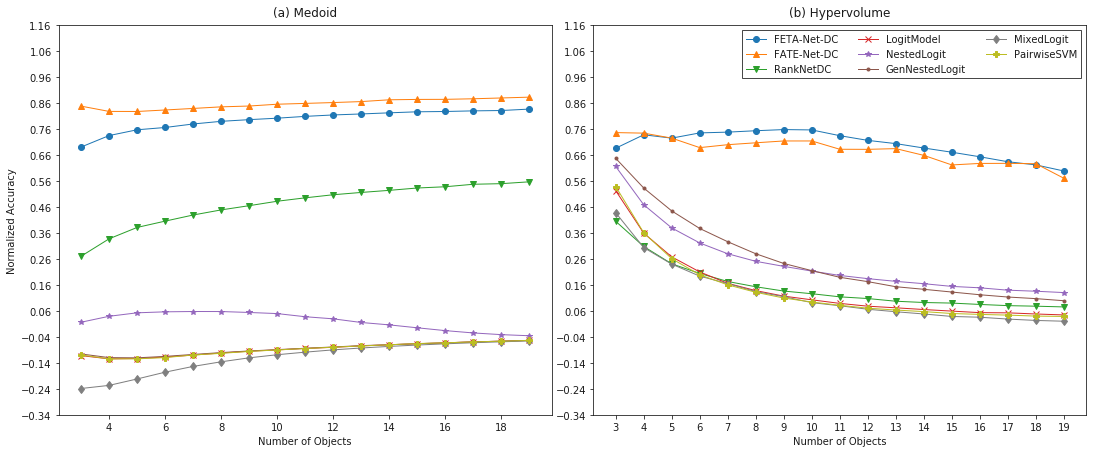

/home/pritha/git/2018-choice-functions/experiments/presentation/generalization_synthetic.png
mnist_dc ['unique', 'median']


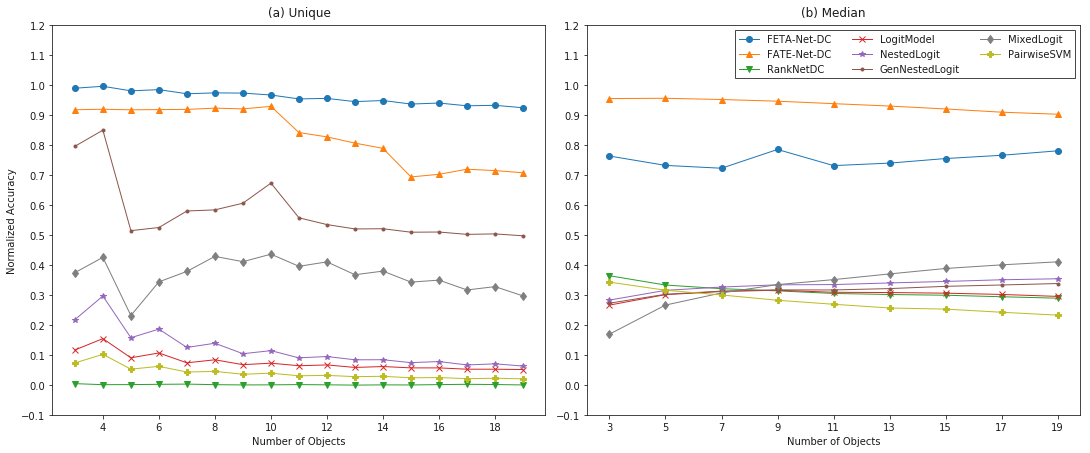

/home/pritha/git/2018-choice-functions/experiments/presentation/generalization_mnist.png
synthetic_dc ['medoid', 'hypervolume']


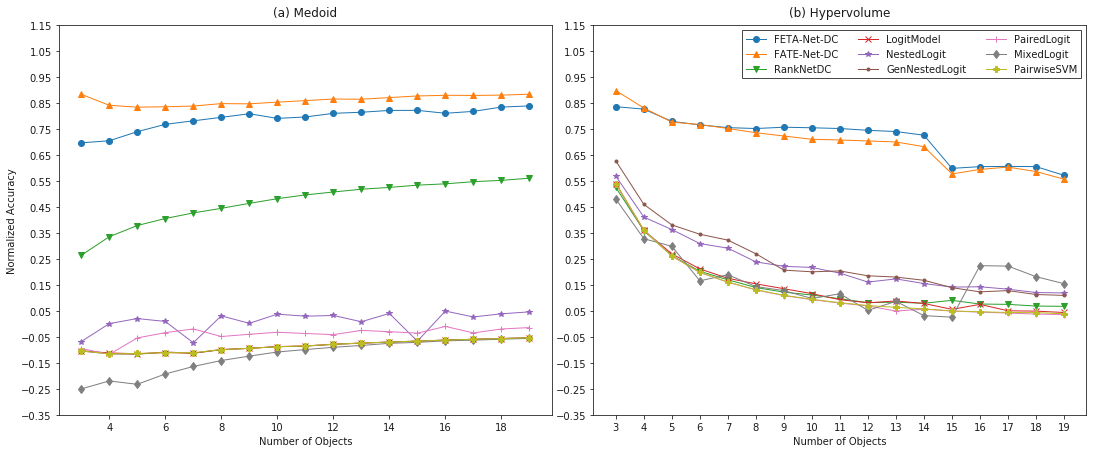

/home/pritha/git/2018-choice-functions/experiments/presentation/performance_synthetic.png
mnist_dc ['unique', 'median']


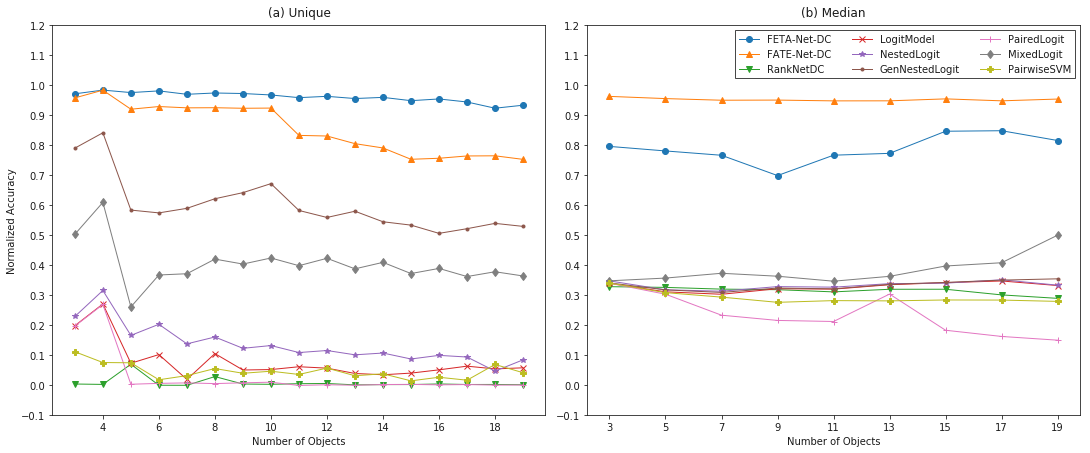

/home/pritha/git/2018-choice-functions/experiments/presentation/performance_mnist.png


In [21]:
ftype = 'png'
THESIS = 'presentation'
objects = "Objects"
MODEL = "aModel"
DIR_PATH = os.getcwd()
RESULT_FOLDER = 'results'
y_label="Normalized Accuracy"
x_label="Number of Objects"
anotation = ['(a)', '(b)','(c)','(d)','(e)','(f)','(g)']
markers = ['o', '^', 'v', 'x', "*", '.', "+", "d","P"]
#models = ['FETA-Net-DC', 'FATE-Net-DC', 'RankNetDC', 'MNL', 'NLM', 'GNL', 'PCL', 'MLM', 'PairwiseSVM']
models = ['FETA-Net-DC', 'FATE-Net-DC', 'RankNetDC', 'LogitModel', 'NestedLogit', 'GenNestedLogit', 'PairedLogit', 'MixedLogit', 'PairwiseSVM']
models_dict = dict(zip(DCMS, models))
datasets = ['synthetic_dc', 'mnist_dc']
dataset_types = [['medoid', 'hypervolume'], ['unique', 'median']]
di = 1
dt = 1
plot_gen = False
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig_param = {'facecolor':'w', 'edgecolor':'w', 'transparent':False, 'dpi':800, 'format':ftype,'bbox_inches':'tight', 'pad_inches':0.1}

plot_file_gen = os.path.join(DIR_PATH, THESIS, "generalization_{}.{}".format('{}',ftype))
plot_file_per = os.path.join(DIR_PATH, THESIS, "performance_{}.{}".format('{}',ftype))
for plot_gen in [True, False]:
    for dataset, dts in zip(datasets, dataset_types):
        print(dataset, dts)
        dfs = []
        for dataset_type in dts:
            dataFrame, N_OBJECTS_ARRAY = generate_df(dataset,dataset_type)
            dfs.append([dataFrame, N_OBJECTS_ARRAY])
            #plot_df(dataFrame, N_OBJECTS_ARRAY, dataset_type)
        plot_df2(dataset, dfs, dts)

In [8]:
import numpy as np
import pandas as pd
from itertools import combinations, product
rs = np.random.RandomState(45)
names = np.array(['a', 'b', 'c', 'd'])
def func(size=4):
    a = np.zeros((size,size))
    for i in range(size):
        for j in range(int(size)):
            a[i,j] = rs.rand(1)[0]
            a[j,i] = 1 - a[i,j] + np.power(-1, rs.randint(5))* 1e-1*rs.rand(1)[0]
    np.fill_diagonal(a, 0)
    return np.around(a,1)

def checkcd(a):
    size =len(a)
    df = pd.DataFrame(a)
    df = df.replace(0.0, '-')
    print(df.to_latex(index=False))
    com = list(combinations(np.arange(size), size-1))
    for c in com:
        c = list(c)
        scores = np.sum(a[np.ix_(c,c)],axis=1)
        print(*names[c], sep=", ")
        print(scores)
        print(names[c[np.argmax(scores)]])
        print('##############################')
    print(np.argmax(np.sum(a, axis=1)))
checkcd(func())
a = func()

\begin{tabular}{llll}
\toprule
   0 &    1 &    2 &    3 \\
\midrule
   - &  0.8 &  0.1 &  0.1 \\
 0.3 &    - &  0.7 &  0.1 \\
 0.9 &  0.3 &    - &  0.7 \\
   1 &    1 &  0.3 &    - \\
\bottomrule
\end{tabular}

a, b, c
[ 0.9  1.   1.2]
c
##############################
a, b, d
[ 0.9  0.4  2. ]
d
##############################
a, c, d
[ 0.2  1.6  1.3]
c
##############################
b, c, d
[ 0.8  1.   1.3]
d
##############################
3


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
import os
DIR_PATH = os.getcwd()
sns.set(color_codes=True)
plt.style.use('default')
plot_file = os.path.join(DIR_PATH, 'thesis', "sigmoid.svg")
def sigmoid(z):
    return 1/(1+np.exp(-z))
x = np.linspace(-8,8, num=200)
y = sigmoid(x)
plt.plot(x,y, 'k')
plt.plot(np.zeros(200),np.linspace(-.02,1.0, num=200), 'k')
plt.plot(np.linspace(-8,8, num=200),np.zeros(200)-.02, 'k')
#plt.gca().set_xticks([])
plt.xticks([])
plt.yticks([])
plt.show()
plt.savefig(plot_file, facecolor='w', edgecolor='w',transparent=False, bbox_inches='tight', pad_inches=0.1 ,dpi=800,format='svg')

<IPython.core.display.Javascript object>


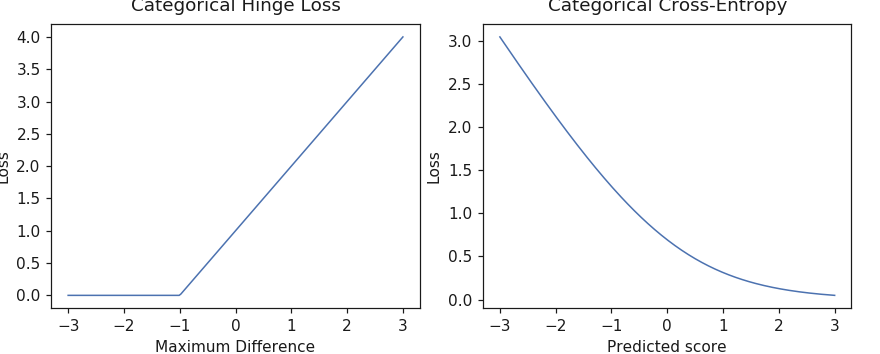

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
import os
from csrank.numpy_util import sigmoid
DIR_PATH = os.getcwd()
sns.set(color_codes=True)
plt.style.use('default')
plot_file = os.path.join(DIR_PATH, 'thesis', "losses.pdf")
fig, axs = plt.subplots(1, 2, figsize=(8,3), sharey=False, frameon=True, edgecolor='k', facecolor='white')
fig.subplots_adjust(hspace=0)
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

inp = np.linspace(-3.0,3.0, num=200)[::-1]
for i in range(2):
    sub_plot = axs[i]
    if i == 0:
        loss = np.maximum(np.zeros_like(inp), 1 + inp)
        title = "Categorical Hinge Loss"
        x_label = "Maximum Difference"
    if i == 1:
        #inp = np.linspace(0,1.0, num=200)
        loss = -1*np.log(sigmoid(inp))
        title = "Categorical Cross-Entropy"
        x_label = "Predicted score"
    sub_plot.set_ylabel("Loss")
    sub_plot.set_xlabel(x_label)
    sub_plot.set_title(title, horizontalalignment='center', verticalalignment='bottom')
    sub_plot.plot(inp, loss, linewidth=1, color='b')
    #sub_plot.set_xticks([])
    #plt.yticks([])
plt.savefig(plot_file, facecolor='w', edgecolor='w',transparent=False, bbox_inches='tight', pad_inches=0.2 ,dpi=800,format='pdf')
plt.show()

In [11]:
from sklearn.datasets import fetch_mldata
import numpy as np
import os
mnist = fetch_mldata('MNIST original', data_home="./")
X_raw = mnist['data'].reshape(-1, 28, 28) / 255.
y = mnist['target']
num_classes = len(np.unique(y))
num_classes

10

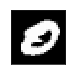

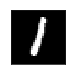

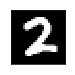

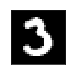

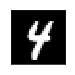

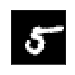

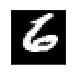

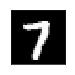

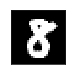

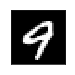

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
fig_param = {'facecolor':'w', 'edgecolor':'w', 'transparent':False, 'dpi':800, 'format':'png','bbox_inches':'tight', 'pad_inches':0.0}

for i in range(10):
    idx = np.where(y==i)[0][-1]
    fig_param["fname"] =  os.path.join(os.getcwd(), 'presentation', "{}.png".format(i))
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(X_raw[idx], cmap = 'gray')
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.savefig(**fig_param)

<IPython.core.display.Javascript object>


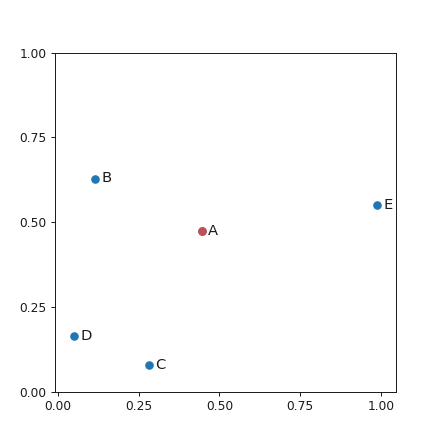

In [8]:
from sklearn.utils import check_random_state
import os
import numpy as np
from scipy.spatial.distance import squareform, pdist
fig_param = {'facecolor':'w', 'edgecolor':'w', 'transparent':False, 'dpi':800, 'format':'png','bbox_inches':'tight', 'pad_inches':0.0}
fig_param["fname"] =  os.path.join(os.getcwd(), 'presentation', "medoid.png")

seed = 45
n_features = 2
n_objects = 5
n_instances = 2
random_state = check_random_state(seed=seed)
X = random_state.uniform(size=(n_objects, n_features))
Y = np.empty(n_objects)
D = squareform(pdist(X, metric='euclidean'))
sum_dist = D.mean(axis=0)
medoid = np.argmin(sum_dist)
Y = np.argsort(np.argsort(D[medoid]))
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
from matplotlib.font_manager import FontProperties
font = FontProperties()
font.set_size('large')
font.set_family('sans-serif')
font.set_weight('medium')
sns.set(color_codes=True)
plt.style.use('default')
#sns.set_style("dark")
fig, ax = plt.subplots(figsize=(5, 5), dpi=80, facecolor='w', edgecolor='w')
ax.scatter(X[:, 0], X[:, 1])
labels = ['A', 'B','C','D','E']
for i in range(n_objects):
    ax.text(X[i, 0]+0.02,
            X[i, 1]-0.01,
            s=labels[Y[i]], color='k',fontproperties=font)
plt.plot(X[medoid, 0], X[medoid, 1], 'ro')
#for x in X:
    #plt.plot([X[medoid, 0],x[0]], [X[medoid, 1],x[1]], color="k",linewidth=0.8)
plt.xticks(np.linspace(0,1,num=5))
plt.yticks(np.linspace(0,1,num=5))
plt.show()
plt.savefig(**fig_param)

[0 4 1 3 2]
[ 0.0452792   0.00721097  0.03901997  0.02777917  0.03467847]
0
[1 3 2 0]
[ 0.0452792   0.00721097  0.03901997  0.05011981]
3


<IPython.core.display.Javascript object>


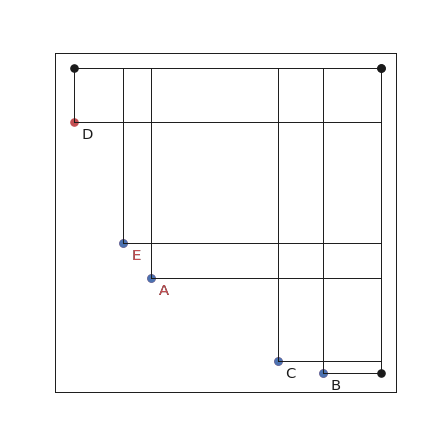

In [14]:
from pygmo import hypervolume
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
from matplotlib.font_manager import FontProperties
seed = 123
n_features = 2
n_objects = 5
n_instances = 2
random_state = check_random_state(seed=seed)
X = random_state.randn(n_objects, n_features)
# Normalize to unit circle and fold to lower quadrant
X = -np.abs(X / np.sqrt(np.power(X, 2).sum(axis=1))[..., None])
Y = np.empty(n_instances, dtype=int)
scores = np.empty((n_objects), dtype=int)
reference = np.zeros(n_features)
boundry = np.array([[np.min(X[:,0]),0], [0,np.min(X[:,1])]])
L = []
L.append(X)
for i in range(n_instances):
    hv = hypervolume(X)
    cont = hv.contributions(reference)
    scores = np.argsort(cont)[::-1].argsort()
    Y[i] = np.argmax(cont)
    print(scores)
    print(cont)
    print(Y[i])
    X = np.delete(X, 3, 0)
    L.append(X)
#print(L[0])
#print(boundry)



sns.set(color_codes=True)
plt.style.use('default')
#sns.set_style("dark")
fig, ax = plt.subplots(figsize=(5, 5), dpi=80, facecolor='w', edgecolor='w')
for b in boundry:
    plt.plot([0,b[0]], [0,b[1]], "ko-",linewidth=0.8)

for b in L[0]:
    plt.plot([b[0],b[0]], [0, b[1]], color="k",linewidth=0.8)
    plt.plot([0, b[0]], [b[1], b[1]], color="k",linewidth=0.8)

cs = ['r', 'b']
labels = ['A', 'B','C','D','E']
font = FontProperties()
font.set_size('large')
font.set_family('sans-serif')
font.set_weight('medium')
fig_param = {'facecolor':'w', 'edgecolor':'w', 'transparent':False, 'dpi':800, 'format':'png','bbox_inches':'tight', 'pad_inches':0.0}
fig_param["fname"] =  os.path.join(os.getcwd(), 'presentation', "hypervolume.png")
for i,l in enumerate(labels):
    x = L[0][i][0]
    y = L[0][i][1]
    ax.text(x+0.025,
            y-0.055,
            s=l, color='k',fontproperties=font)
    if i ==0 or i==4:
        ax.text(x+0.025,
            y-0.055,
            s=l, color='r',fontproperties=font)
for i in range(2):
    ax.scatter(L[i][:, 0], L[i][:, 1], color=cs[i])
    #for i in range(n_objects):
        #ax.text(X[inst, i, 0]+0.01,
         #       X[inst, i, 1]+0.01,
         #       s=scores[inst, i])
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
#ax.set_ylabel("Criteria 1")
#ax.set_xlabel("Criteria 2")
plt.show()
plt.savefig(**fig_param)

<IPython.core.display.Javascript object>


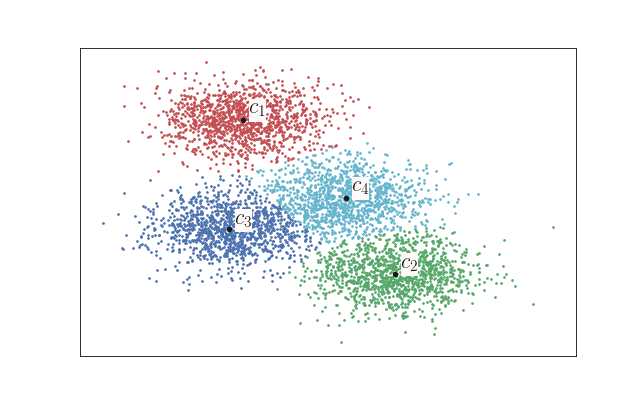

In [54]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.font_manager import FontProperties
from sklearn.datasets.samples_generator import make_blobs
%matplotlib notebook
sns.set(color_codes=True)
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='cursive', size=20, weight='heavy')
#sns.set_style("dark")
plot_file = os.path.join(os.getcwd(), THESIS, "clustering.svg")
fig = plt.figure(figsize=(8, 5), dpi=80, facecolor='None', edgecolor='None')
N = 5000
rs = np.random.RandomState(42)
k=4
X, y = make_blobs(n_samples=N, centers=k, n_features=2, random_state=0, center_box=(-10.0, 10.0), cluster_std=0.9)
kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
centers = kmeans.cluster_centers_
labels = kmeans.labels_
colors = ['r', 'g', 'b', 'c']
for i in range(4):
    idx = np.where(labels==i)[0]
    txt = r'$c_{}$'.format(i+1)
    plt.scatter(X[idx, 0], X[idx, 1], marker='o', color=colors[i], s=2)
    plt.text(centers[i, 0]+0.12, centers[i, 1]+0.12, s=str(txt), color='k',
             bbox=dict(facecolor='snow', edgecolor='None', pad=0))
plt.scatter(centers[:, 0], centers[:, 1], marker='o', color='k', s=15)
plt.xticks([])
plt.yticks([])
plt.show()
plt.savefig(plot_file, dpi=None, facecolor='None', edgecolor='None', orientation='portrait', format='svg', bbox_inches = 'tight', pad_inches = 0)

In [3]:
DIR_PATH = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
log_path = os.path.join(DIR_PATH, 'logs', 'test.log')
setup_logger(log_path=log_path)
logger = logging.getLogger('Test')
config_file_path = os.path.join(DIR_PATH, 'config', 'clusterdb.json')
dataset = "mnist_dc"
dataset_type = "unique"
schema = 'masterthesis'

In [4]:
self = DBConnector(config_file_path=config_file_path, is_gpu=False, schema=schema)

In [5]:
self.get_job_for_id(job_id=219, cluster_id=5533)

Jobs found 
job_id => 219
fold_id => 3
dataset => synthetic_dc
learner => feta_dc
experiment_schema => results
experiment_table => discrete_choice
dataset_params => {'dataset_type': 'hypervolume', 'n_test_instances': 100000, 'n_train_instances': 10000, 'n_features': 2, 'n_objects': 10}
fit_params => {'epochs': 500, 'callbacks': {'DebugOutput': {'delta': 200}, 'LRScheduler': {'epochs_drop': 200, 'drop': 0.1}}}
learner_params => {'add_zeroth_order_model': 'TRUE'}
hp_ranges => {'feta_dc': {'n_hidden': [2, 20], 'n_units': [20, 40], 'learning_rate': [1e-05, 0.01, 'log-uniform'], 'reg_strength': [1e-10, 0.1, 'log-uniform'], 'batch_size': [128, 1024]}, 'LRScheduler': {'epochs_drop': [100, 250], 'drop': [0.01, 0.5, 'log-uniform']}}
hp_fit_params => {}
hp_iters => 50
is_gpu => True
seed => 42
inner_folds => 1
duration => 5D
learning_problem => discrete_choice
validation_loss => None
hash_value => 111584636f7816fa82e41a7ec3ab73623d4e9198
job_allocated_time => 2018-08-10 16:00:10.363999

Job with

In [26]:
self.init_connection(cursor_factory=None)
job_id = 89
update_result = "INSERT INTO results.discrete_choice (job_id, cluster_id, CategoricalAccuracy, CategoricalTopK2, CategoricalTopK3, CategoricalTopK4, CategoricalTopK5, CategoricalTopK6) VALUES (89, 6285379, 0.9615, 0.9770, 0.9824, 0.9867, 0.9895, 0.9916)"

self.cursor_db.execute(update_result)
if self.cursor_db.rowcount == 1:
    print("Results inserted for the job {}".format(job_id))
self.close_connection()

Results inserted for the job 89


In [6]:
self.init_connection()
avail_jobs = '{}.avail_jobs'.format(schema)
self.cursor_db.execute("SELECT * from {} where job_id={}".format(avail_jobs, 102))
job_desc = self.cursor_db.fetchall()
job_desc = dict(job_desc[0])
print(job_desc)
query_job_id = job_desc['job_id']
del job_desc['job_id']
learner, learner_params  = job_desc['learner'], job_desc['learner_params']
dataset, dataset_type = job_desc['dataset'], job_desc['dataset_params']['dataset_type']
print(learner_params)
fold_id = 1
select_job = "SELECT job_id, learner_params from {} where fold_id = {} AND learner = \'{}\' AND " \
            "dataset = \'{}\' AND dataset_params->>'dataset_type' = \'{}\'".format(avail_jobs, fold_id,
                                                                                            learner, dataset,
                                                                                            dataset_type)
print("Select job for duplication {}".format(select_job))
self.cursor_db.execute(select_job)
new_job_id = None
if self.cursor_db.rowcount != 0:
    query = self.cursor_db.fetchone()
    if learner_params == query['learner_params']:
        new_job_id = query['job_id']
        print("The job {} with fold {} already exist".format(new_job_id, fold_id))
if new_job_id is None:
    keys = list(job_desc.keys())
    columns = ', '.join(keys)
    index = keys.index('fold_id')
    keys[index] = str(fold_id)
    values_str = ', '.join(keys)
    insert_job = "INSERT INTO {0} ({1}) SELECT {2} FROM {0} where {0}.job_id = {3} RETURNING job_id".format(
        avail_jobs, columns, values_str, query_job_id)
    print("Inserting job with new fold: {}".format(insert_job))
    self.cursor_db.execute(insert_job)
    new_job_id = self.cursor_db.fetchone()[0]

print("Job {} with fold id {} updated/inserted".format(new_job_id, fold_id))

{'job_id': 102, 'fold_id': 0, 'dataset': 'synthetic_dc', 'learner': 'feta_dc', 'experiment_schema': 'results', 'experiment_table': 'discrete_choice', 'dataset_params': {'dataset_type': 'hypervolume', 'n_test_instances': 100000, 'n_train_instances': 10000, 'n_features': 2, 'n_objects': 10}, 'fit_params': {'epochs': 500, 'callbacks': {'DebugOutput': {'delta': 200}, 'LRScheduler': {'epochs_drop': 200, 'drop': 0.1}}}, 'learner_params': {'add_zeroth_order_model': 'TRUE'}, 'hp_ranges': {'feta_dc': {'n_hidden': [2, 20], 'n_units': [20, 40], 'learning_rate': [1e-05, 0.01, 'log-uniform'], 'reg_strength': [1e-10, 0.1, 'log-uniform'], 'batch_size': [128, 1024]}, 'LRScheduler': {'epochs_drop': [100, 250], 'drop': [0.01, 0.5, 'log-uniform']}}, 'hp_fit_params': {}, 'hp_iters': 50, 'is_gpu': True, 'seed': 42, 'inner_folds': 1, 'duration': '5D', 'learning_problem': 'discrete_choice', 'validation_loss': 'None', 'hash_value': '111584636f7816fa82e41a7ec3ab73623d4e9198', 'job_allocated_time': datetime.dat

In [4]:
self.init_connection()
select_st = "SELECT * FROM {0} WHERE {0}.dataset=\'{1}\' AND dataset_params->>'dataset_type'=\'{2}\'".format(
    '{0}', dataset, dataset_type)
self.cursor_db.execute(select_st.format('pymc3.avail_jobs'))
run_jobs = []
for job in self.cursor_db.fetchall():
    if job['fold_id']==0:
        run_jobs.append(dict(job))
self.cursor_db.execute(select_st.format('masterthesis.avail_jobs'))
for job in self.cursor_db.fetchall():
    if job['fold_id']==0:
        run_jobs.append(dict(job))

In [38]:
df_path = 'test.csv'
MODEL = "aModel"
from csrank.constants import GEV, NLM, PCL, MNL
rows_list = []
N_OBJECTS_ARRAY = np.arange(3, 20)
for job in run_jobs:
    learner_name = job['learner']
    hp_ranges = job["hp_ranges"]
    add_in_name = ''
    if job['learner_params'].get("add_zeroth_order_model", False):
        add_in_name = '_zero'
    eval_results = {MODEL: '{}{}'.format(learner_name, add_in_name)}
    for n in N_OBJECTS_ARRAY:
        eval_results[n] = np.random.rand(1)[0]
    rows_list.append(eval_results)
    if learner_name not in [MNL, PCL]:
        for n_objects in [3, 5, 7, 13, 15]:
            if 'n_nests' in hp_ranges[learner_name]:
                hp_ranges[learner_name]['n_nests'] = [2, np.max([3, int(n_objects / 2) + 1])]
                print(hp_ranges)
        eval_results = {MODEL: '{}{}_optimized'.format(learner_name, add_in_name)}
        for n in N_OBJECTS_ARRAY:
            eval_results[n] = np.random.rand(1)[0]
        rows_list.append(eval_results)
df = pd.DataFrame(rows_list)
df = df.set_index(MODEL).T
df.insert(0, 'Objects',  N_OBJECTS_ARRAY)
df.to_csv(df_path, index=False)
df

{'generalized_extreme_value': {'loss_function': ['categorical_crossentropy', 'binary_crossentropy', 'categorical_hinge'], 'regularization': ['l1', 'l2'], 'n_nests': [2, 3]}}
{'generalized_extreme_value': {'loss_function': ['categorical_crossentropy', 'binary_crossentropy', 'categorical_hinge'], 'regularization': ['l1', 'l2'], 'n_nests': [2, 3]}}
{'generalized_extreme_value': {'loss_function': ['categorical_crossentropy', 'binary_crossentropy', 'categorical_hinge'], 'regularization': ['l1', 'l2'], 'n_nests': [2, 4]}}
{'generalized_extreme_value': {'loss_function': ['categorical_crossentropy', 'binary_crossentropy', 'categorical_hinge'], 'regularization': ['l1', 'l2'], 'n_nests': [2, 7]}}
{'generalized_extreme_value': {'loss_function': ['categorical_crossentropy', 'binary_crossentropy', 'categorical_hinge'], 'regularization': ['l1', 'l2'], 'n_nests': [2, 8]}}
{'nested_logit_model': {'loss_function': ['categorical_crossentropy', 'binary_crossentropy', 'categorical_hinge'], 'regularization

aModel,Objects,paired_combinatorial_logit,generalized_extreme_value,generalized_extreme_value_optimized,multinomial_logit_model,nested_logit_model,nested_logit_model_optimized,ranknet_dc,ranknet_dc_optimized,feta_dc,feta_dc_optimized,fate_dc,fate_dc_optimized,ranksvm_dc,ranksvm_dc_optimized,feta_dc_zero,feta_dc_zero_optimized
3,3,0.007673,0.519001,0.701689,0.625134,0.809790,0.203564,0.294969,0.497309,0.979272,0.122342,0.642475,0.363660,0.072989,0.222863,0.176422,0.938181
4,4,0.186642,0.338343,0.723219,0.143816,0.112630,0.250749,0.870692,0.418525,0.673838,0.721559,0.415323,0.564485,0.618432,0.021765,0.978005,0.312323
5,5,0.158710,0.010400,0.736726,0.814655,0.807995,0.514309,0.373872,0.465996,0.560657,0.496669,0.524501,0.677825,0.104190,0.196219,0.465982,0.682675
6,6,0.191692,0.010023,0.072824,0.533200,0.079392,0.094299,0.412338,0.476072,0.345074,0.067444,0.196976,0.610741,0.884783,0.739198,0.015212,0.830992
7,7,0.463104,0.927262,0.399163,0.757651,0.073654,0.657214,0.281082,0.546669,0.415743,0.354195,0.560253,0.738780,0.986782,0.840662,0.714326,0.299941
8,8,0.443480,0.264455,0.192727,0.691651,0.887552,0.080788,0.722463,0.440278,0.908643,0.363235,0.256721,0.892142,0.939709,0.059261,0.077921,0.984806
9,9,0.700078,0.474631,0.515140,0.426925,0.453136,0.500621,0.168948,0.137939,0.485543,0.107180,0.185987,0.933043,0.252047,0.729499,0.419479,0.434028
10,10,0.507011,0.411053,0.672190,0.828013,0.058736,0.529003,0.249911,0.449516,0.950764,0.044210,0.508774,0.974001,0.896306,0.563107,0.945694,0.189275
11,11,0.479200,0.422658,0.945886,0.571072,0.897613,0.543339,0.712071,0.877810,0.236270,0.350826,0.403482,0.483017,0.908195,0.131869,0.418216,0.349421
12,12,0.261080,0.193467,0.546906,0.067656,0.065778,0.308630,0.437999,0.187557,0.397995,0.288104,0.185589,0.773793,0.262849,0.639002,0.581344,0.129521


In [31]:
df = pd.read_csv(df_path)
df

,Objects,paired_combinatorial_logit,paired_combinatorial_logit_optimized,generalized_extreme_value,generalized_extreme_value_optimized,multinomial_logit_model,multinomial_logit_model_optimized,nested_logit_model,nested_logit_model_optimized,ranknet_dc,ranknet_dc_optimized,feta_dc,feta_dc_optimized,fate_dc,fate_dc_optimized,ranksvm_dc,ranksvm_dc_optimized,feta_dc_zero,feta_dc_zero_optimized
0,3,0.334542,0.745759,0.143301,0.302669,0.960770,0.573841,0.429012,0.112022,0.363135,0.244278,0.049521,0.814273,0.150589,0.248833,0.347361,0.715454,0.904724,0.400459
1,4,0.176129,0.002039,0.091508,0.942269,0.273274,0.358319,0.442459,0.864507,0.982331,0.683012,0.727323,0.991537,0.705881,0.664490,0.475989,0.826989,0.097984,0.981545
2,5,0.832365,0.628150,0.631161,0.293459,0.165713,0.769881,0.329043,0.896628,0.741195,0.018030,0.279380,0.944711,0.474522,0.547178,0.064404,0.789603,0.886032,0.574858
3,6,0.896146,0.446629,0.496637,0.093086,0.314574,0.288972,0.924660,0.843456,0.371468,0.910481,0.629261,0.300153,0.483716,0.120983,0.452849,0.969878,0.241684,0.677906
4,7,0.312140,0.373960,0.117998,0.900610,0.619509,0.271351,0.986320,0.820056,0.468373,0.788141,0.089173,0.376173,0.270568,0.266458,0.493375,0.336702,0.391204,0.723527
5,8,0.074676,0.421638,0.477792,0.341199,0.622704,0.809523,0.741929,0.841939,0.040371,0.182557,0.941594,0.822022,0.161795,0.180578,0.395199,0.389349,0.117881,0.749365
6,9,0.166182,0.515389,0.400294,0.231093,0.844784,0.385017,0.729770,0.807458,0.605507,0.856611,0.621445,0.030776,0.907095,0.042753,0.485967,0.531787,0.036283,0.579765
7,10,0.336234,0.256563,0.875260,0.026791,0.583825,0.663003,0.617590,0.725323,0.614006,0.376816,0.607985,0.619601,0.762022,0.740634,0.816681,0.872050,0.891949,0.085660
8,11,0.690827,0.983807,0.058391,0.157946,0.500169,0.865375,0.567820,0.477856,0.244728,0.671243,0.603307,0.180970,0.887687,0.101982,0.948323,0.733217,0.293799,0.979632
9,12,0.391485,0.283933,0.235294,0.239503,0.640651,0.702854,0.689858,0.852917,0.536861,0.553548,0.254788,0.528496,0.261889,0.615350,0.249105,0.147065,0.191716,0.791612


In [33]:
models_done = list(df.columns)
models_done

['Objects',
 'paired_combinatorial_logit',
 'paired_combinatorial_logit_optimized',
 'generalized_extreme_value',
 'generalized_extreme_value_optimized',
 'multinomial_logit_model',
 'multinomial_logit_model_optimized',
 'nested_logit_model',
 'nested_logit_model_optimized',
 'ranknet_dc',
 'ranknet_dc_optimized',
 'feta_dc',
 'feta_dc_optimized',
 'fate_dc',
 'fate_dc_optimized',
 'ranksvm_dc',
 'ranksvm_dc_optimized',
 'feta_dc_zero',
 'feta_dc_zero_optimized']

In [36]:
for n_objects in [3, 5, 7, 13, 15]:
    print([2, np.max([3, int(n_objects / 2) + 1])])

[2, 3]
[2, 3]
[2, 4]
[2, 7]
[2, 8]


In [47]:
import pandas as pd
df_ = pd.read_csv('scores.csv', index_col=None)
print(len(df_))
df_.head()

100000


,x,y,score
0,0.487035,0.964832,0.202445
1,0.517571,0.325367,0.860106
2,0.906303,0.613380,0.483603
3,0.929999,0.965174,0.226089
4,0.936650,0.692189,0.437663


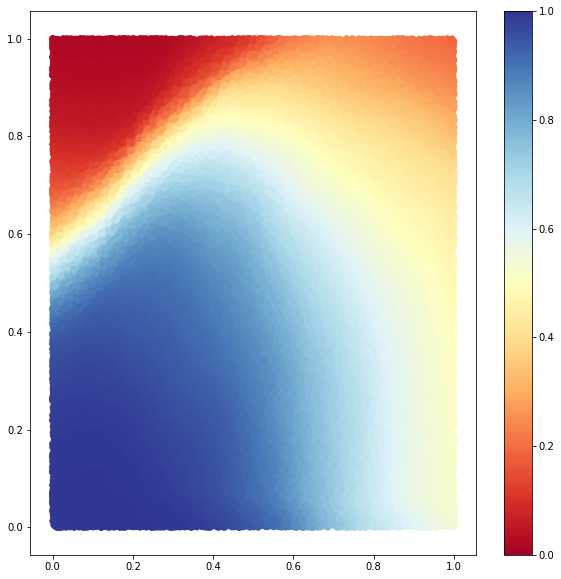

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
import numpy as np
%matplotlib inline
values = df_.as_matrix()
fig, ax = plt.subplots(figsize=(10,10))
norm = Normalize(vmin=0, vmax=1)
cmap = plt.cm.get_cmap('RdYlBu') #get_cmap('Spectral')
colors = np.array([cmap(v) for v in values[:, 2]])
sc = plt.scatter(values[:, 0],values[:, 1], c=values[:, 2], vmin=0, vmax=1, cmap=cmap)
plt.colorbar(sc)
plt.show()